# Récupération des prévisions météo des villes sélectionnées

## Imports python

In [ ]:
import pandas as pd
import requests
import datetime
import plotly.express as px
import plotly.io as pio

from etl import compute_weather_score

from config import (
    secrets,
    CITIES_GEO_LOCATION_CSV_PATH,
    CITIES_WEATHER_FORECAST_CSV_PATH,
    CITIES_GEO_LOCATION_AND_SCORE_CSV_PATH
)

# display settings
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', 1000)          # Expand display width
pd.set_option('display.max_colwidth', None)   # Show full content in each cell

# Allow to view a preview image within Github
pio.renderers.default = "jupyterlab+png"

Data folder: /workspaces/jedha-cdsd-cert-projects/bloc-1/kayak/data


## Chargement des villes géo-localisées

In [2]:
if not CITIES_GEO_LOCATION_CSV_PATH.exists():
    print("Please run notebook 01-b1-kayak-destinations.ipynb first!")
else:
    print("Loading cities...")
    cities_df = pd.read_csv(CITIES_GEO_LOCATION_CSV_PATH)
    display(cities_df)

Loading cities...


,id,name,latitude,longitude
0,1,Mont Saint Michel,48.635954,-1.511460
1,2,St Malo,48.649518,-2.026041
2,3,Bayeux,49.276462,-0.702474
3,4,Le Havre,49.493898,0.107973
4,5,Rouen,49.440459,1.093966
5,6,Paris,48.858890,2.320041
6,7,Amiens,49.894171,2.295695
7,8,Lille,50.636565,3.063528
8,9,Strasbourg,48.584614,7.750713
9,10,Chateau du Haut Koenigsbourg,48.249411,7.344320


## Fonction d'interrogation de l'API de prévisions météorologiques (openweathermap API)


In [4]:
OPENWEATHERMAP_FORECAST_API_URL = 'http://api.openweathermap.org/data/2.5/forecast'

# Request
# GET weather forecast for a given location (60 calls/minute, 1000 calls/day)
def get_daily_weather_forecast_at_location(latitude: float, longitude: float) -> pd.DataFrame:
    try:
        print(f"Retrieving weather forecast for latitude {latitude} and longitude {longitude}")
        response = requests.get(
            url=OPENWEATHERMAP_FORECAST_API_URL,
            params={
                "lat": latitude,
                "lon": longitude,
                "units": "metric",
                "lang" : "fr",
                "appid": secrets["OPENWEATHERMAP_API_KEY"],
            },
        )
        response.raise_for_status()
    except requests.exceptions.RequestException:
        print('HTTP Request failed')
    else:
        payload_json = response.json()

        # Normalize weather nested array of one item (will be merged to main dataframe)
        weather = pd.json_normalize(payload_json, ['list', 'weather'])

        # JSON to dataframe
        df = pd.json_normalize(payload_json, record_path='list')

        # convert dt to datetime type
        df.dt = pd.to_datetime(df.dt, unit='s')

        # rename a few columns
        df.rename(columns={'main.temp': 'temp'}, inplace=True)
        df.rename(columns={'main.temp_min': 'temp_min'}, inplace=True)
        df.rename(columns={'main.temp_max': 'temp_max'}, inplace=True)
        df.rename(columns={'main.humidity': 'humidity'}, inplace=True)
        df.rename(columns={'main.pressure': 'pressure'}, inplace=True)
    
        df.rename(columns={'clouds.all': 'clouds'}, inplace=True)
        df.rename(columns={'rain.3h': 'rain'}, inplace=True)
        
        df.rename(columns={'wind.speed': 'wind_speed'}, inplace=True)
        
        # merge weather
        df['weather_main'] = weather['main']
        df['weather_description'] = weather['description']
        df['weather_icon'] = weather['icon']
        df['weather_id'] = weather['id']

        # convert pop to percentage
        df['pop']=round(100 * df['pop'], 2)

        # remove unused
        remove_main_cols = [col for col in df.columns if col.startswith('main.')]
        df.drop(columns=remove_main_cols, inplace=True)
        df.drop(columns=['dt_txt', 'weather', 'wind.deg', 'wind.gust', 'sys.pod'], inplace=True)

        return df

    return None


In [5]:
retrieve_forecast = True

if CITIES_WEATHER_FORECAST_CSV_PATH.exists():
    # Check if forecast is old, as it is just demo, refreshing every 24h is enough
    cities_weather_forecast_df = pd.read_csv(CITIES_WEATHER_FORECAST_CSV_PATH)
    # convert dt to datetime type
    cities_weather_forecast_df.dt = pd.to_datetime(cities_weather_forecast_df.dt)

    oldest = min(cities_weather_forecast_df.dt)

    if datetime.datetime.now() - oldest < datetime.timedelta(hours=24):
        print("Existing forecast is still fresh enough, keeping.")
        retrieve_forecast = False
    else:
        print("Old forecast exists, refreshing.")
        retrieve_forecast = True

if retrieve_forecast:    
    cities_weather_forecast_df = pd.DataFrame()
    print(f"Retrieving weather forecast for {len(cities_df)} cities...")

    for city in cities_df.itertuples():
        # Retrieve forecast for the next 5 days
        weather_df = get_daily_weather_forecast_at_location(city.latitude, city.longitude)
        
        weather_df.insert(0, "city_id", city.id, allow_duplicates=True)

        cities_weather_forecast_df = pd.concat([cities_weather_forecast_df, weather_df])

    # Save forecast
    cities_weather_forecast_df.to_csv(CITIES_WEATHER_FORECAST_CSV_PATH, index=False, encoding="utf-8")

display(cities_weather_forecast_df.describe())
display(cities_weather_forecast_df.head(20))


Old forecast exists, refreshing.
Retrieving weather forecast for 35 cities...
Retrieving weather forecast for latitude 48.6359541 and longitude -1.51146


Retrieving weather forecast for latitude 48.649518 and longitude -2.0260409
Retrieving weather forecast for latitude 49.2764624 and longitude -0.7024738
Retrieving weather forecast for latitude 49.4938975 and longitude 0.1079732
Retrieving weather forecast for latitude 49.4404591 and longitude 1.0939658
Retrieving weather forecast for latitude 48.8588897 and longitude 2.320041
Retrieving weather forecast for latitude 49.8941708 and longitude 2.2956951
Retrieving weather forecast for latitude 50.6365654 and longitude 3.0635282
Retrieving weather forecast for latitude 48.584614 and longitude 7.7507127
Retrieving weather forecast for latitude 48.2494107 and longitude 7.3443202
Retrieving weather forecast for latitude 48.0777517 and longitude 7.3579641
Retrieving weather forecast for latitude 48.0447968 and longitude 7.3079618
Retrieving weather forecast for latitude 47.2380222 and longitude 6.0243622
Retrieving weather forecast for latitude 47.3215806 and longitude 5.0414701
Retrieving we

,city_id,dt,visibility,pop,temp,temp_min,temp_max,pressure,humidity,clouds,wind_speed,rain,weather_id
count,1400.000000,1400,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,403.000000,1400.000000
mean,18.000000,2025-04-20 22:30:00,9909.810000,21.115714,12.529564,12.504871,12.581707,1011.466429,74.799286,78.416429,3.644471,1.276948,715.869286
min,1.000000,2025-04-18 12:00:00,154.000000,0.000000,0.740000,0.740000,0.740000,999.000000,28.000000,0.000000,0.130000,0.100000,500.000000
25%,9.000000,2025-04-19 17:15:00,10000.000000,0.000000,10.147500,10.140000,10.197500,1008.000000,64.000000,64.000000,1.827500,0.230000,500.000000
50%,18.000000,2025-04-20 22:30:00,10000.000000,0.000000,12.350000,12.315000,12.370000,1013.000000,77.000000,96.000000,3.020000,0.480000,803.000000
75%,27.000000,2025-04-22 03:45:00,10000.000000,23.000000,15.062500,14.992500,15.102500,1015.000000,87.000000,100.000000,4.850000,1.290000,804.000000
max,35.000000,2025-04-23 09:00:00,10000.000000,100.000000,24.200000,24.200000,24.830000,1021.000000,100.000000,100.000000,17.000000,16.530000,804.000000
std,10.103114,NaN,656.116047,36.361296,3.543351,3.518401,3.575789,4.907611,15.332358,30.090526,2.569820,2.114532,137.222236


,city_id,dt,visibility,pop,temp,temp_min,temp_max,pressure,humidity,clouds,wind_speed,rain,weather_main,weather_description,weather_icon,weather_id
0,1,2025-04-18 12:00:00,10000,100.0,10.19,10.19,10.19,1008,91,100,8.42,1.16,Rain,légère pluie,10d,500
1,1,2025-04-18 15:00:00,10000,100.0,10.56,10.56,11.30,1007,91,100,7.14,0.60,Rain,légère pluie,10d,500
2,1,2025-04-18 18:00:00,10000,100.0,11.02,11.02,11.43,1005,88,100,7.06,0.87,Rain,légère pluie,10d,500
3,1,2025-04-18 21:00:00,10000,20.0,11.33,11.33,11.33,1002,87,100,7.21,0.12,Rain,légère pluie,10n,500
4,1,2025-04-19 00:00:00,10000,28.0,11.33,11.33,11.33,1002,95,100,7.03,0.52,Rain,légère pluie,10n,500
5,1,2025-04-19 03:00:00,10000,100.0,11.55,11.55,11.55,1001,95,100,5.60,1.17,Rain,légère pluie,10n,500
6,1,2025-04-19 06:00:00,10000,100.0,11.89,11.89,11.89,1001,92,100,5.43,0.17,Rain,légère pluie,10d,500
7,1,2025-04-19 09:00:00,10000,0.0,13.32,13.32,13.32,1003,84,98,4.56,NaN,Clouds,couvert,04d,804
8,1,2025-04-19 12:00:00,10000,20.0,15.40,15.40,15.40,1002,75,98,2.25,0.21,Rain,légère pluie,10d,500
9,1,2025-04-19 15:00:00,10000,100.0,14.35,14.35,14.35,1002,87,100,2.08,1.81,Rain,légère pluie,10d,500


## Calcul du score d'attraction pour les villes

Définition et calcul d'un score arbitraire basé sur les prévisions météo pour établir un classement des villes.

La moyenne des température l'aprés-midi et les risques de pluie

In [ ]:
scoring_df = compute_weather_score(cities_weather_forecast_df)

cities_and_score_df = cities_df.merge(scoring_df, left_on="id", right_on="city_id")

display(cities_and_score_df.head(5))

cities_and_score_df.to_csv(CITIES_GEO_LOCATION_AND_SCORE_CSV_PATH, index=False, encoding="utf-8")

,id,name,latitude,longitude,mean_temp,min_pop,mean_pop,max_pop
0,1,Mont Saint Michel TOTO,48.635954,-1.511460,12.47,20.62,45.33,80.00
1,2,St Malo,48.649518,-2.026041,12.14,21.50,40.42,84.25
2,3,Bayeux,49.276462,-0.702474,13.00,0.00,28.73,70.00
3,4,Le Havre,49.493898,0.107973,12.58,0.00,39.27,75.00
4,5,Rouen,49.440459,1.093966,14.10,0.00,27.12,61.62


## Preview de la carte des villes avec une indication d'attractivité

La visualisation permet de visualiser l'attractivité des villes.

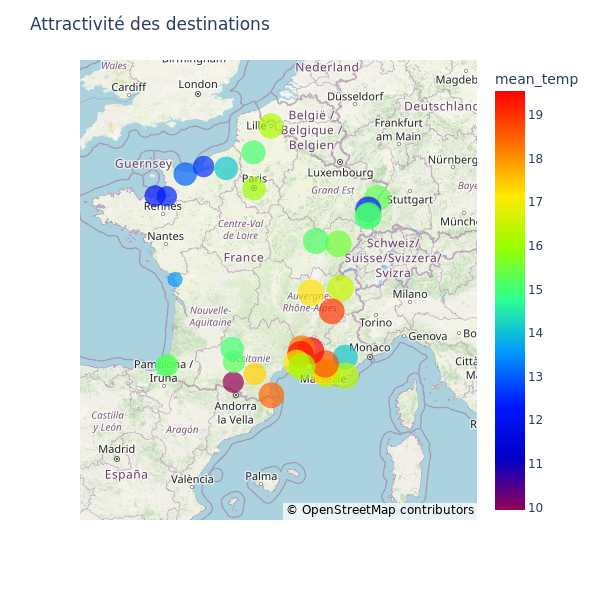

In [5]:
# To have size bigger when weather is dryer!
cities_and_score_df["mean_not_pop"] = 100 - cities_and_score_df["mean_pop"]

fig = px.scatter_map(
    cities_and_score_df,
    lat="latitude",
    lon="longitude",
    hover_data="name",
    color="mean_temp",
    size="mean_not_pop",
    color_continuous_scale=px.colors.sequential.Rainbow,
    map_style="open-street-map",
    zoom=4,
    height=600,
    width=600
)

fig.update_geos(fitbounds="locations")

fig.update_layout(
    title="Attractivité des destinations",
)
fig.show()